In [ ]:
##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 作为 DataFrame 访问 TensorBoard 数据

## 概述

TensorBoard 的主要特性是其交互式 GUI。不过，用户有时会希望**以编程方式**读取存储在 TensorBoard 中的数据日志，以达成执行事后分析和创建日志数据的自定义可视化效果等目的。

TensorBoard 2.3 通过 `tensorboard.data.experimental.ExperimentFromDev()` 支持此用例。它允许以编程方式访问 TensorBoard 的[标量日志](https://tensorflow.google.cn/tensorboard/scalars_and_keras)。本页面将演示这个新 API 的基本用法。

> **注：**
>
> 1. 可以从 API 命名空间看出，此 API 仍处于实验阶段。这意味着此 API 未来可能发生重大变更。
> 2. 目前，此功能仅支持上传到 TensorBoard.dev（一项用于保留和共享 TensorBoard 的免费托管服务）的 logdir。未来会添加对本地存储的 TensorBoard logdir 的支持。简而言之，您可以使用以下单行命令将本地文件系统上的 TensorBoard logdir 上传到 TensorBoard.dev：`tensorboard dev upload --logdir <logdir>`。有关更多详细信息，请参阅 [tensorboard.dev](https://tensorboard.dev) 上的文档。

## 设置

为了使用编程式 API，请确保在安装 `tensorboard` 的同时安装 `pandas`。

在本指南中，我们将使用 `matplotlib` 和 `seaborn` 进行自定义绘图，但您可以选择首选工具来分析和可视化 `DataFrame`。

In [ ]:
!pip install -q tensorboard pandas
!pip install -q matplotlib seaborn

In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [2]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.3.0a20200626


## 作为 `pandas.DataFrame` 加载 TensorBoard 标量

Once a TensorBoard logdir has been uploaded to TensorBoard.dev, it becomes what we refer to as an *experiment*. Each experiment has a unique ID, which can be found in the TensorBoard.dev URL of the experiment. For our demonstration below, we will use a TensorBoard.dev experiment at: https://tensorboard.dev/experiment/c1KCv3X3QvGwaXfgX1c4tg

In [3]:
experiment_id = "c1KCv3X3QvGwaXfgX1c4tg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

run             tag  step     value
0         adam,run_1/train  epoch_accuracy     0  0.966867
1         adam,run_1/train  epoch_accuracy     1  0.986283
2         adam,run_1/train  epoch_accuracy     2  0.989333
3         adam,run_1/train  epoch_accuracy     3  0.991933
4         adam,run_1/train  epoch_accuracy     4  0.991733
...                    ...             ...   ...       ...
1195  sgd,run_5/validation      epoch_loss    15  0.020157
1196  sgd,run_5/validation      epoch_loss    16  0.020212
1197  sgd,run_5/validation      epoch_loss    17  0.020364
1198  sgd,run_5/validation      epoch_loss    18  0.022192
1199  sgd,run_5/validation      epoch_loss    19  0.032140

[1200 rows x 4 columns]

`df` 是一个 [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)，其中包含实验的所有标量日志。

`DataFrame` 的各列为：

- `run`：每个运行都对应一个原始 logdir 的子目录。在此实验中，每个运行都来自 MNIST 数据集上卷积神经网络 (CNN) 的一个完整训练集，该训练集具有给定的优化器类型（训练超参数）。此 `DataFrame` 包含多个此类运行，这些运行对应于不同优化器类型下的重复训练运行。
- `tag`：此列描述同一行中 `value` 的含义，即该值在该行中表示的指标。在此实验中，我们只有两个唯一标记：`epoch_accuracy` 和 `epoch_loss`，分别用于准确率和损失指标。
- `step`：这是一个数字，反映相应行在其运行中的序列顺序。这里的 `step` 实际指的是周期数。如果希望在获取 `step` 值之外获取时间戳，可以在调用 `get_scalars()` 时使用关键字参数 `include_wall_time=True`。
- `value`：这是我们所关注的实际数值。如上所述，此特定 `DataFrame` 中的每个 `value` 要么是损失，要么是准确率，具体取决于该行的 `tag`。

In [4]:
print(df["run"].unique())
print(df["tag"].unique())

['adam,run_1/train' 'adam,run_1/validation' 'adam,run_2/train'
 'adam,run_2/validation' 'adam,run_3/train' 'adam,run_3/validation'
 'adam,run_4/train' 'adam,run_4/validation' 'adam,run_5/train'
 'adam,run_5/validation' 'rmsprop,run_1/train' 'rmsprop,run_1/validation'
 'rmsprop,run_2/train' 'rmsprop,run_2/validation' 'rmsprop,run_3/train'
 'rmsprop,run_3/validation' 'rmsprop,run_4/train'
 'rmsprop,run_4/validation' 'rmsprop,run_5/train'
 'rmsprop,run_5/validation' 'sgd,run_1/train' 'sgd,run_1/validation'
 'sgd,run_2/train' 'sgd,run_2/validation' 'sgd,run_3/train'
 'sgd,run_3/validation' 'sgd,run_4/train' 'sgd,run_4/validation'
 'sgd,run_5/train' 'sgd,run_5/validation']
['epoch_accuracy' 'epoch_loss']


## 获取透视（宽格式）DataFrame

在我们的实验中，两个标记（`epoch_loss` 和 `epoch_accuracy`）在每个运行中都出现在相同的一组步骤中。这样就可以通过使用 `pivot=True` 关键字参数直接从 `get_scalars()` 获取“宽格式”`DataFrame`。宽格式 `DataFrame` 的所有标记都包含在 DataFrame 列中，这在某些情况（包括本实验）下更加便于使用。

但是请注意，如果不满足条件（即所有运行中的所有标记具有统一的步骤值集合），使用 `pivot=True` 将导致错误。

In [5]:
dfw = experiment.get_scalars(pivot=True) 
dfw

run  step  epoch_accuracy  epoch_loss
0        adam,run_1/train     0        0.966867    0.110196
1        adam,run_1/train     1        0.986283    0.042437
2        adam,run_1/train     2        0.989333    0.032622
3        adam,run_1/train     3        0.991933    0.026121
4        adam,run_1/train     4        0.991733    0.024742
..                    ...   ...             ...         ...
595  sgd,run_5/validation    15        0.993800    0.020157
596  sgd,run_5/validation    16        0.993500    0.020212
597  sgd,run_5/validation    17        0.993800    0.020364
598  sgd,run_5/validation    18        0.993100    0.022192
599  sgd,run_5/validation    19        0.990800    0.032140

[600 rows x 4 columns]

Notice that instead of a single "value" column, the wide-form DataFrame includes the two tags (metrics) as its columns explicitly: `epoch_accuracy` and `epoch_loss`.

## 将 DataFrame 保存为 CSV

`pandas.DataFrame` has good interoperability with [CSV](https://en.wikipedia.org/wiki/Comma-separated_values). You can store it as a local CSV file and load it back later. For example:

In [6]:
csv_path = '/tmp/tb_experiment_1.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

## 执行自定义可视化和统计分析

Text(0.5, 1.0, 'loss')

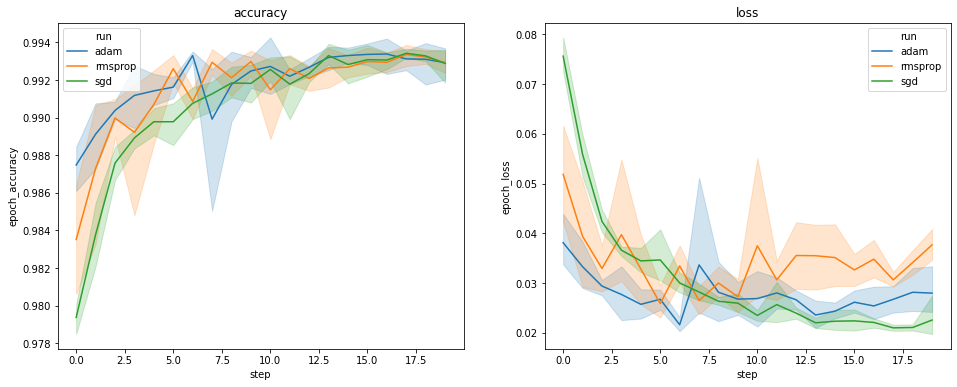

In [7]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 2, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

上图显示了验证准确率和验证损失的时间进程。每条曲线显示了一种优化器类型下的 5 次运行的平均值。由于 `seaborn.lineplot()` 的内置功能，每条曲线还围绕平均值显示 ±1 标准偏差，这使我们能够清楚地了解这些曲线的变化以及这三种优化器类型之间差异的显著性。TensorBoard 的 GUI 尚不支持这种变化的可视化。

我们想要研究以下假设：最小验证损失在“adam”、“rmsprop”和“sgd”优化器之间存在显著差异。因此，我们提取 DataFrame，以在每种优化器下获得最小的验证损失。

然后，我们制作一个箱形图，可视化最小验证损失中的差异。

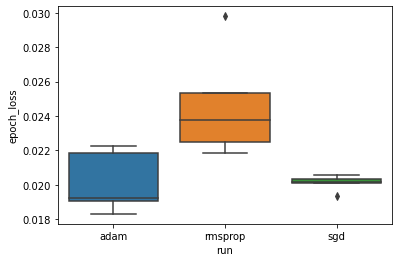

In [8]:
adam_min_val_loss = dfw_validation.loc[optimizer_validation=="adam", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
rmsprop_min_val_loss = dfw_validation.loc[optimizer_validation=="rmsprop", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
sgd_min_val_loss = dfw_validation.loc[optimizer_validation=="sgd", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
min_val_loss = pd.concat([adam_min_val_loss, rmsprop_min_val_loss, sgd_min_val_loss])

sns.boxplot(data=min_val_loss, y="epoch_loss",
            x=min_val_loss.run.apply(lambda run: run.split(",")[0]))

In [9]:
# Perform pairwise comparisons between the minimum validation losses
# from the three optimizers.
_, p_adam_vs_rmsprop = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    rmsprop_min_val_loss["epoch_loss"]) 
_, p_adam_vs_sgd = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
_, p_rmsprop_vs_sgd = stats.ttest_ind(
    rmsprop_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
print("adam vs. rmsprop: p = %.4f" % p_adam_vs_rmsprop)
print("adam vs. sgd: p = %.4f" % p_adam_vs_sgd)
print("rmsprop vs. sgd: p = %.4f" % p_rmsprop_vs_sgd)

adam vs. rmsprop: p = 0.0244
adam vs. sgd: p = 0.9749
rmsprop vs. sgd: p = 0.0135


因此，在显著水平为 0.05 时，我们的分析证实了我们的假设：rmsprop 优化器中的最低验证损失明显高于（即更差）我们实验中包含的其他两种优化器。

概括一下，本教程提供了一个示例，介绍了如何以 `panda.DataFrame` 的形式从 TensorBoard.dev 访问标量数据。教程演示了您可以使用 `DataFrame` 进行的灵活而强大的分析和可视化。